<h1><center> AVO Attributes</center></h1>

This tutorial demonstrates how to import well log data, segy data, display avo crossplots and compute attributes at near/far stack. 

__Part 1__

Generate Acoustic impedance, Normalized elastic impedance, lambda-mu-rho, AVO and angle gathers.

_Dataset:_ well 5 from Avseth et al. (2010)

In [1]:
#Import Libraries
from pyavo.avotools import log_crossplot as log
from pyavo.seismodel import angle_stack as stk
import lasio
import numpy as np
import pandas as pd

In [2]:
lasio.__version__

'0.28'

__1. Load and explore well log data__

In [3]:
well_5 = lasio.read('./data/well_5.las')

In [4]:
well_5.version

[HeaderItem(mnemonic="VERS", unit="", value="2.0", descr="CWLS Log ASCII Stan...),
 HeaderItem(mnemonic="WRAP", unit="", value="NO", descr="One Line per depth S...)]

In [5]:
print(well_5.curves)

Mnemonic  Unit  Value  Description   
--------  ----  -----  -----------   
DEPT      m                          
VP        km/s         Vp(in Km/s)   
VS        km/s         Vs(in km/s)   
GR        GAPI         Gamma Ray     
RHOB      G/C3         Bulk Density  


In [6]:
# Display log values
for curve in well_5.curves:
    print(curve.mnemonic + ": " + str(curve.data))

DEPT: [2100.072  2100.2244 2100.3767 ... 2299.7161 2299.8684 2300.0208]
VP: [127.134 128.017 128.512 ... 102.649 101.361 100.464]
VS: [312.372 313.654 313.706 ... 206.796 201.336 199.016]
GR: [ 86.778  90.658 102.479 ...  66.681  63.133  62.938]
RHOB: [2.262 2.26  2.267 ... 2.224 2.186 2.171]


In [7]:
well_5.data.shape # Get shape of data

(1313, 5)

In [8]:
well_5.well.CTRY # Get well location

HeaderItem(mnemonic="CTRY", unit="", value="NORWAY", descr="Nation")

In [9]:
# Extract Depth, Vp, vs, vp/vs, density and GR form data
z_well = well_5['DEPT'] # depth
vp_well = well_5['VP'] * 1e3 # P-wave velocity convert to m/s
vs_well = well_5['VS'] * 1e3 # S-wave velocity convert to m/s
vpvs_well = well_5['VP'] / well_5['VS'] # Vp/Vs
gr_well = well_5['GR'] # Gamma ray
rho_well = well_5['RHOB'] # Density

In [10]:
print(f'Minimum Depth: {z_well.min()}m') # Min depth
print(f'Maximum Depth: {z_well.max()}m') # Max depth

Minimum Depth: 2100.072m
Maximum Depth: 2300.0208m


__2. Compute porosity from fluid and mineral density__

In [11]:
# Parameters from Avseth et al. (2001) and Avseth et al. (2005)

rho_qtz = 2.65 # Density of quartz mineral
rho_fl = 1.05 # Density of fluid

phi_well = (rho_qtz - rho_well)/(rho_qtz - rho_fl) # Porosity

In [12]:
well_dict = {'Depth': z_well,
             'Gr': gr_well,
             'Rho': rho_well, 
             'Vp': vp_well, 
             'Vs': vs_well,
             'VpVs': vpvs_well,
             'PHI': phi_well
            }

well_df = pd.DataFrame(data=well_dict)

In [13]:
well_df.head()

,Depth,Gr,Rho,Vp,Vs,VpVs,PHI
0,2100.0720,86.778,2.262,127134.0,312372.0,0.406996,0.242500
1,2100.2244,90.658,2.260,128017.0,313654.0,0.408147,0.243750
2,2100.3767,102.479,2.267,128512.0,313706.0,0.409657,0.239375
3,2100.5293,114.549,2.272,128534.0,316362.0,0.406288,0.236250
4,2100.6816,118.948,2.275,128309.0,321356.0,0.399274,0.234375


 __3. Display log plots of Poisson ratio, AI and NEI.__

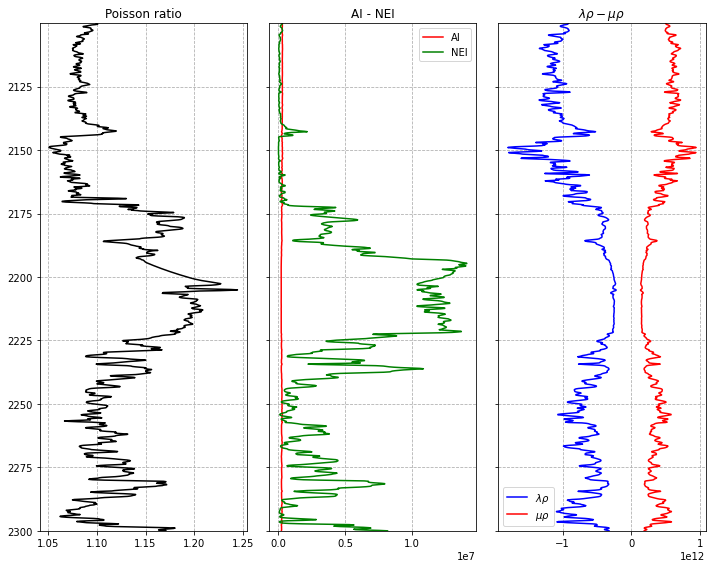

In [14]:
im = log.plot_imp(vpvs=vpvs_well, vp=vp_well, vs=vs_well, 
                  rho=rho_well, angle=30, h_well=z_well, h_ref=2170)

3. Display Cross plots

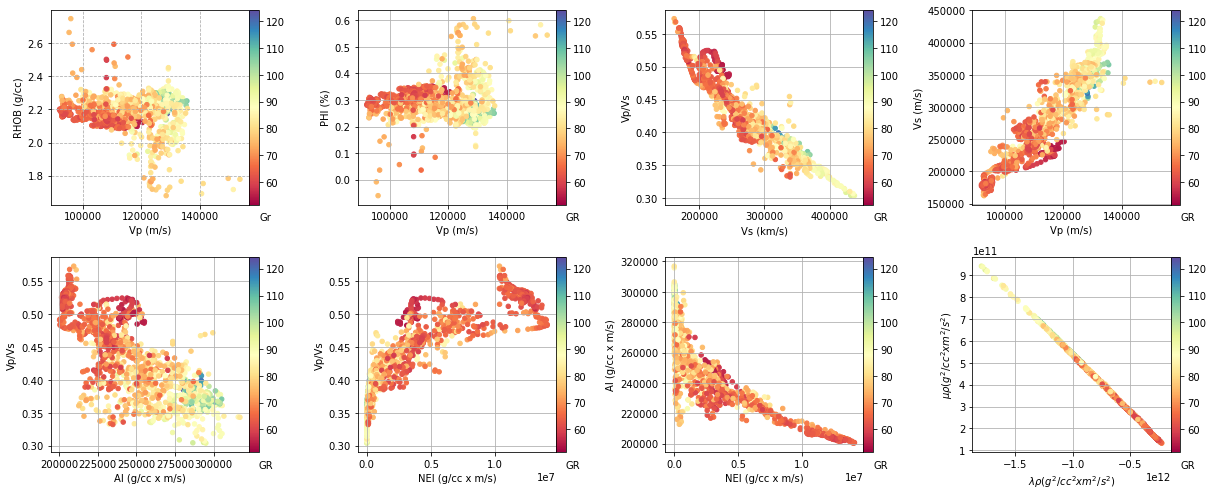

In [15]:
log.crossplot(vp=vp_well, vs=vs_well, vpvs=vpvs_well, rho=rho_well, 
              phi=phi_well, GR=gr_well, AI=im['AI'], NEI=im['NEI'], 
              lambda_rho=im['lambda_rho'], mu_rho=im['mu_rho'])

__4. Compute intercept and gradient__

In [16]:
angle = np.arange(0, 31, 1) # Angles of incidence

#get the closest location of the top on the depth array as reference to NEI
top = (np.abs(z_well - 2170)).argmin()
step = top + 1

vp0, vs0, rho0 = vp_well[top], vs_well[top], rho_well[top]
vp1, vs1, rho1 =  vp_well[step], vs_well[step], rho_well[step]


# Compute intercept , gradient & shuey 2-terms approximation
intercept, gradient, shuey, _ = log.shuey(vp0, vs0, rho0, vp1, vs1, rho1, angle)

In [17]:
print(f'Intercept: {intercept}, Gradient: {gradient}')

Intercept: 0.02330746530457032, Gradient: -1.1029345848521164


__5. Plot AVO__

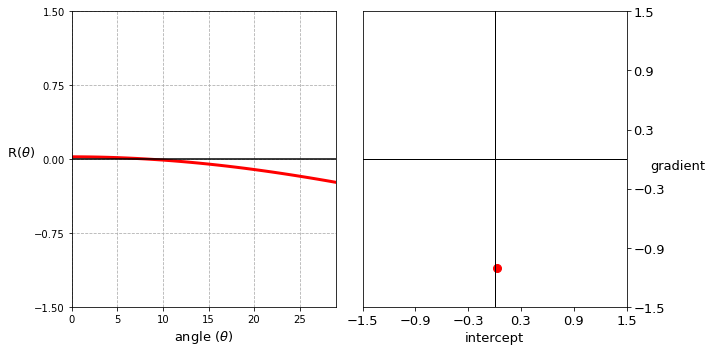

In [18]:
log.avo_plot(angle, shuey, intercept, gradient)

__Part 2__

Compute AVO attributes from the Near and Far volumes available from Avseth et al. (2010)

__1. Read near and far stack segy data into a data array__

In [19]:
near_data_array = stk.read_segy('./data/3d_nearstack.sgy', byte_il=41, byte_xl=21)

number of traces: 25351, samples: 250, sample rate: 4.0 s
first, last sample twt: 1500.0, 2496.0 s
file_size: 24.18 Mb (0.02 Gb)
inlines: 101, min=1300.0, max=1500.0
crosslines: 251, min=1500, max=2000


In [20]:
far_data_array = stk.read_segy('./data/3d_farstack.sgy', byte_il=41, byte_xl=21)

number of traces: 25351, samples: 250, sample rate: 4.0 s
first, last sample twt: 1500.0, 2496.0 s
file_size: 24.18 Mb (0.02 Gb)
inlines: 101, min=1300.0, max=1500.0
crosslines: 251, min=1500, max=2000


In [21]:
near_data_array

<xarray.DataArray (IL: 101, XL: 251, TWT: 250)>
array([[[   87., -2478., -2540., ...,   788.,  -567., -1523.],
        [  296., -3341., -3521., ...,  -562.,  -619.,  -551.],
        [ -222., -4529., -3452., ...,  -767.,  -779.,  -760.],
        ...,
        [-1763., -1145.,   173., ...,  1061.,   679.,   169.],
        [-2774., -2650.,   255., ...,  1411.,   114.,    12.],
        [-1290., -2921., -1348., ...,  3142.,   715., -1083.]],

       [[ 1682., -2405., -4558., ...,    44.,    60.,  -842.],
        [ 2664., -1708., -4861., ..., -1207.,   364.,   735.],
        [ 1622., -3359., -3590., ..., -1298.,  -141.,   496.],
        ...,
        [ 1421., -2042., -3536., ...,  1023.,   175.,  -836.],
        [-1651., -2253., -1203., ...,  1807.,   583.,  -308.],
        [ -908., -2005., -2233., ...,  2868.,   725., -1255.]],

       [[ 3942.,   -53., -4479., ..., -1873.,  -811.,   471.],
        [ 2844.,   538., -3253., ..., -1633.,  1037.,  2180.],
        [ 1326.,  -538., -2350., ..., -1253.,   328.,   800.],
        ...,
...
        [-1199., -2843., -1054., ...,  -767.,  -409.,   306.],
        [-1535., -1651.,  -238., ...,  -188.,  -169.,   -35.],
        [ -911.,  -706.,    36., ...,   566.,   415.,    24.]],

       [[-1366.,   823.,  2195., ...,  -291.,  3592.,  4207.],
        [-1989.,   662.,  2284., ..., -1194.,  2648.,  4521.],
        [-1152.,  1683.,  1997., ..., -2127.,  1717.,  4715.],
        ...,
        [-1887., -4144.,  -631., ...,  -522.,   418.,   744.],
        [-3795., -3623.,  1733., ...,  -644.,   367.,   819.],
        [-1516., -2573.,   176., ...,  -656.,  -598.,   -67.]],

       [[  879.,  1385.,   284., ...,   123.,  3014.,  3600.],
        [  599.,   718.,    70., ...,   641.,  2535.,  2798.],
        [  114.,  2807.,  1612., ...,   181.,  1317.,  2583.],
        ...,
        [-1357., -1617.,  1174., ...,  -974.,   431.,  1464.],
        [-3853., -3118.,  2662., ..., -1052.,   730.,  1310.],
        [-3180., -3194.,  2491., ..., -1234.,  -516.,    32.]]],
      dtype=float32)
Coordinates:
  * IL       (IL) float64 1.3e+03 1.302e+03 1.304e+03 ... 1.498e+03 1.5e+03
  * XL       (XL) int32 1500 1502 1504 1506 1508 ... 1992 1994 1996 1998 2000
  * TWT      (TWT) float64 1.5e+03 1.504e+03 1.508e+03 ... 2.492e+03 2.496e+03

In [22]:
far_data_array

<xarray.DataArray (IL: 101, XL: 251, TWT: 250)>
array([[[  -97., -1197., -1473., ...,   736.,   454.,   102.],
        [ -235.,  -714., -1326., ...,  1095.,  1397.,   706.],
        [ 1263.,  -501., -2641., ...,  1585.,   942.,  -127.],
        ...,
        [  962.,  -735., -2468., ..., -1360.,   718.,  2232.],
        [ 1294.,  -934., -2622., ...,  -833.,   812.,  1129.],
        [ 1511.,  -336., -2407., ...,  -211.,  1104.,   863.]],

       [[ 1342.,   390., -1646., ...,  -264.,    -4.,   515.],
        [ 2617.,  2110., -1703., ...,   570.,   846.,   371.],
        [ 1843.,  1770., -1109., ...,   570.,   496.,   -58.],
        ...,
        [  772.,  -320., -2268., ...,  -849.,   894.,  2681.],
        [  520.,  -718., -1898., ...,   112.,  1240.,  1599.],
        [  605., -1644., -2281., ...,   561.,  1164.,  1471.]],

       [[  768.,   652., -1209., ...,   718.,   801.,   307.],
        [ 1633.,  2244.,  -727., ...,   737.,   237.,  -435.],
        [ 1429.,  1420.,  -969., ...,   -47.,   242.,   298.],
        ...,
...
        [ 1215.,   195.,  -920., ...,  -377.,    33.,   320.],
        [ 1318.,  1161.,  -394., ...,  -213.,   290.,   265.],
        [  250.,  1190.,   831., ...,    98.,   294.,   182.]],

       [[-1080., -1906.,  -715., ..., -3167., -1376.,  1345.],
        [  -93.,  -977.,  -754., ..., -2285., -1118.,  1080.],
        [  -89.,  -278.,   -23., ..., -1468.,    91.,  1733.],
        ...,
        [ 1610.,   524., -1060., ...,   570.,   590.,   149.],
        [ 1456.,   359.,  -544., ...,    68.,   333.,   323.],
        [ 1016.,   -12.,  -671., ...,  -371.,    74.,   468.]],

       [[-1492., -2858.,  -768., ..., -2828., -1683.,   797.],
        [   49., -1751., -2117., ...,  -725.,  -594.,    31.],
        [  136.,   100.,   -35., ...,  -712.,   320.,  1085.],
        ...,
        [ 2058., -1021., -2301., ...,  1814.,  1355.,    32.],
        [ 1893.,  -646., -1274., ...,   432.,   662.,   542.],
        [  950.,  -775.,  -326., ...,  -724.,   667.,  1124.]]],
      dtype=float32)
Coordinates:
  * IL       (IL) float64 1.3e+03 1.302e+03 1.304e+03 ... 1.498e+03 1.5e+03
  * XL       (XL) int32 1500 1502 1504 1506 1508 ... 1992 1994 1996 1998 2000
  * TWT      (TWT) float64 1.5e+03 1.504e+03 1.508e+03 ... 2.492e+03 2.496e+03

2. Display Near and Far angle stacks from DataArray

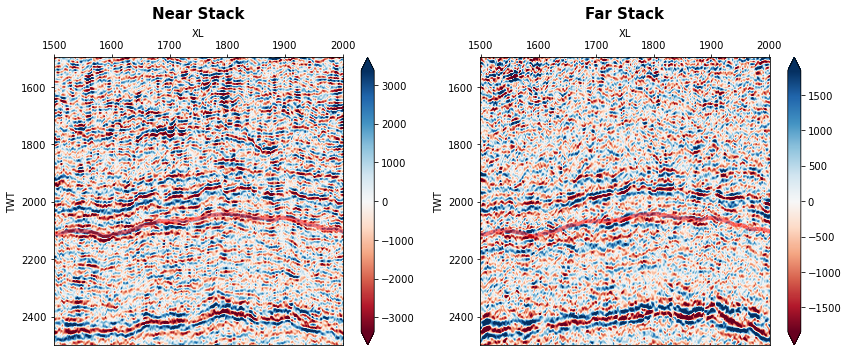

In [23]:
stk.nfstack(horizon_data='./data/Top_Heimdal_subset.txt', near_stack=near_data_array, 
            far_stack=far_data_array, inline=1376)

 3. Display near and far angle stack attributes

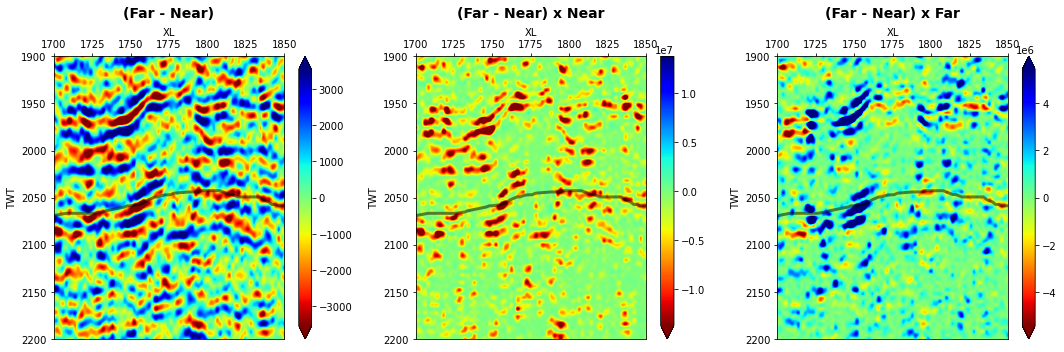

In [24]:
stk.nf_attributes(horizon_data='./data/Top_Heimdal_subset.txt', near_stack=near_data_array, 
              far_stack=far_data_array, TWT_slice=(1900, 2200), 
              XL_slice=(1700, 1850), inline=1376)

 4. Display AVO attributes and crossplot

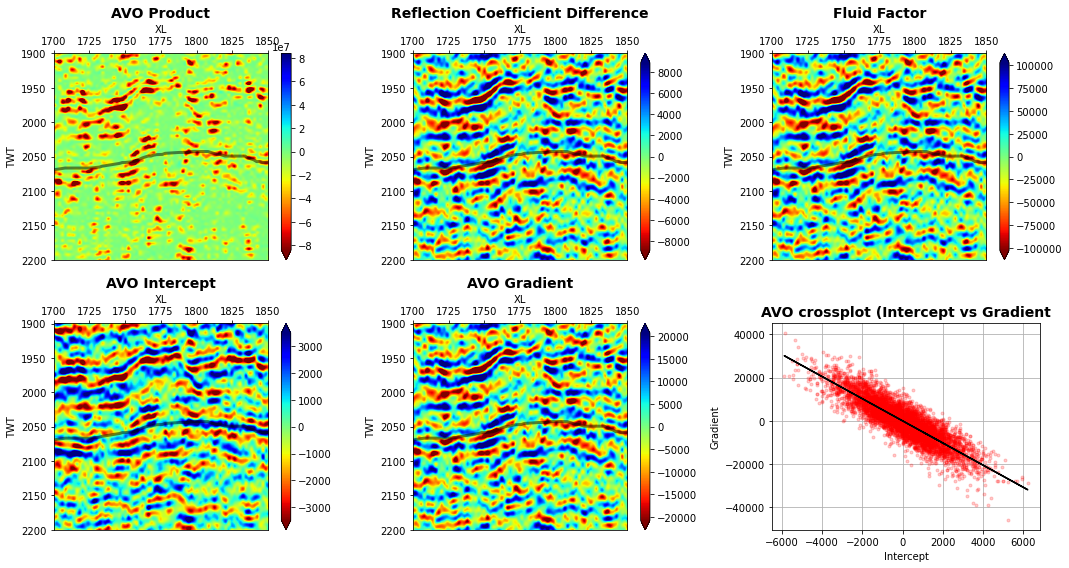

In [25]:
avo_dict = stk.avo_attributes(horizon_data='./data/Top_Heimdal_subset.txt', near_stack=near_data_array, 
                              far_stack=far_data_array, theta_near=5, theta_far=25, 
                              TWT_slice=(1900, 2200), XL_slice=(1700, 1850), inline=1376)

In [26]:
avo_dict

{'Intercept': <xarray.DataArray (XL: 251, TWT: 250)>
 array([[-1404.6321  , -2998.8384  ,  -211.36218 , ...,    21.637764,
         -1337.9442  ,  -792.6777  ],
        [-1076.131   , -2299.9636  ,   337.14697 , ...,  1233.4932  ,
           564.4191  ,  -128.89064 ],
        [ -616.2278  ,  -575.8109  ,   591.14355 , ...,  -218.55013 ,
          -951.16174 ,  -578.09564 ],
        ...,
        [-2899.4033  ,  1015.89746 ,  2720.771   , ...,    59.216385,
          -962.8952  , -1293.3258  ],
        [-1942.0912  ,  2032.2916  ,  2392.2598  , ...,   -66.2426  ,
           542.0615  ,    52.251724],
        [-1076.3987  ,  1151.1094  ,  1326.5468  , ...,  -193.3269  ,
          1714.5331  ,  1883.2177  ]], dtype=float32)
 Coordinates:
     IL       float64 1.376e+03
   * XL       (XL) int32 1500 1502 1504 1506 1508 ... 1992 1994 1996 1998 2000
   * TWT      (TWT) float64 1.5e+03 1.504e+03 1.508e+03 ... 2.492e+03 2.496e+03,
 'Gradient': <xarray.DataArray (XL: 251, TWT: 250)>
 array([[  2

__References:__
    
Avseth, P., Mukerji, T., & Mavko, G., 2010. Quantitative seismic interpretation: Applying rock physics tools to reduce interpretation risk. Cambridge university press.

Shuey,R.T., 1985, A simplification of Zoeppritz equations: Geophysics, 50, 609–614.

Alessandro del Monte - Playing with seismic https://github.com/aadm/geophysical_notes/blob/master/playing_with_seismic.ipynb

Alessandro del Monte - Seismic amplitude extraction https://github.com/aadm/geophysical_notes/blob/master/seismic_amplitude_extraction.ipynb

Castagna, J. P., and Smith, S. W., 1994. Comparison of AVO indicators: A modeling study. Geophysics, 59, 1849-1855.

Ross, C. P., and Kinman, D. L., 1995. Nonbright-spot AVO; two examples. Geophysics, 60(5), 1398-1408.

The dataset: https://srb.stanford.edu/quantitative-seismic-interpretation

https://github.com/ffigura/avo/tree/master/3_real_angle_stack_avseth

https://github.com/ffigura/avo/tree/master/2_real_well_avseth
